In [42]:
!pip install pennylane 
!pip install strawberryfields 
!pip install PennyLane-SF 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

import pennylane as qml
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

from tqdm import tqdm

In [44]:
from sklearn.datasets import load_iris

import numpy as np
from sklearn.decomposition import PCA

import torch
from torch.autograd import Variable
import torch.optim as optim

# Importing Data

In [46]:
num_features = 4
NUM_ZONES = 3

In [76]:
# X_feature_size = 4 # CHANGING VARIABLE
# iris = load_iris()
# X = iris.data[:, :X_feature_size]
# y = iris.target

data = np.load("data/data_3.npz", allow_pickle=True)["arr_0"][()]
X = np.array(data["pressure"])
y = np.array(data["zone_hits"]["data"])
num_sensors = X.shape[1]

pca = PCA(n_components = num_features)
pca.fit(X)
data_pca = pca.transform(X)
X = data_pca

num_data_points = 150
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
indices = indices[:num_data_points]
X = X[indices]
y = y[indices]

In [77]:
X.shape

(150, 4)

In [78]:
y.shape

(150,)

# Building Hybrid Quantum Model

In [51]:
np.random.seed(0)
torch.manual_seed(0)

num_zones = 2**NUM_ZONES # X zones - CHANGE
margin = 0.15
feature_size = num_features  
batch_size = 10 
lr_adam = 0.01
train_split = 0.75
# the number of the required qubits is calculated from the number of features
num_qubits = int(np.ceil(np.log2(feature_size)))
num_layers = 6
total_iterations = 100   # Maybe changes to 50

dev = qml.device("default.qubit", wires=num_qubits)

### Quantum Circuit

In [52]:
# a single layer represents one variational circuit
def layer(W):
    for i in range(num_qubits):
        qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)
    for j in range(num_qubits - 1):
        qml.CNOT(wires=[j, j + 1])
    if num_qubits >= 2:
        # Apply additional CNOT to entangle the last with the first qubit
        qml.CNOT(wires=[num_qubits - 1, 0])

In [53]:
def circuit(weights, feat=None):
    qml.AmplitudeEmbedding(feat, range(num_qubits), pad_with=0.0, normalize=True)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))


qnodes = []
for iq in range(num_zones):
    qnode = qml.QNode(circuit, dev, interface="torch")
    qnodes.append(qnode)

In [54]:
def variational_classifier(q_circuit, params, feat):
    weights = params[0]
    bias = params[1]
    return q_circuit(weights, feat=feat) + bias

### Loss Function

In [55]:
def multiclass_svm_loss(q_circuits, all_params, feature_vecs, true_labels):
    loss = 0
    num_samples = len(true_labels)
    for i, feature_vec in enumerate(feature_vecs):
        # Compute the score given to this sample by the classifier corresponding to the
        # true label. So for a true label of 1, get the score computed by classifer 1,
        # which distinguishes between "class 1" or "not class 1".
        s_true = variational_classifier(
            q_circuits[int(true_labels[i])],
            (all_params[0][int(true_labels[i])], all_params[1][int(true_labels[i])]),
            feature_vec,
        )
        s_true = s_true.float()
        li = 0

        # Get the scores computed for this sample by the other classifiers
        for j in range(num_zones):
            if j != int(true_labels[i]):
                s_j = variational_classifier(
                    q_circuits[j], (all_params[0][j], all_params[1][j]), feature_vec
                )
                s_j = s_j.float()
                li += torch.max(torch.zeros(1).float(), s_j - s_true + margin)
        loss += li

    return loss / num_samples

### Classification

In [56]:
def classify(q_circuits, all_params, feature_vecs, labels):
    predicted_labels = []
    raw_preds = []
    for i, feature_vec in enumerate(feature_vecs):
        scores = np.zeros(num_zones)
        for c in range(num_zones):
            score = variational_classifier(
                q_circuits[c], (all_params[0][c], all_params[1][c]), feature_vec
            )
            scores[c] = float(score)
        pred_class = np.argmax(scores)
        predicted_labels.append(pred_class)
        raw_preds.append(scores)
    return predicted_labels, raw_preds


def accuracy(labels, hard_predictions):
    loss = 0
    for l, p in zip(labels, hard_predictions):
        if torch.abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / labels.shape[0]
    return loss

In [57]:
def process_data(X_data, y_data):
    X = torch.tensor(X_data)

    # normalize each input
    normalization = torch.sqrt(torch.sum(X ** 2, dim=1))
    X_norm = X / normalization.reshape(len(X), 1)

    Y = torch.tensor(y_data)
    return X_norm, Y

### Training Procedure

In [58]:
def training(features, Y):
    num_data = Y.shape[0]
    feat_vecs_train, feat_vecs_test, Y_train, Y_test = train_test_split(features, Y, test_size= 1 - train_split, random_state=42)
    num_train = Y_train.shape[0]
    q_circuits = qnodes

    # Initialize the parameters
    all_weights = [
        Variable(0.1 * torch.randn(num_layers, num_qubits, 3), requires_grad=True)
        for i in range(num_zones)
    ]
    all_bias = [Variable(0.1 * torch.ones(1), requires_grad=True) for i in range(num_zones)]
    optimizer = optim.Adam(all_weights + all_bias, lr=lr_adam)
    params = (all_weights, all_bias)
    print("Num params: ", 3 * num_layers * num_qubits * 3 + 3)

    costs, train_acc, test_acc = [], [], []
    raw_train, raw_test = [], []

    # train the variational classifier
    for it in tqdm(range(total_iterations)):
        batch_index = np.random.randint(0, num_train, (batch_size,))
        feat_vecs_train_batch = feat_vecs_train[batch_index]
        Y_train_batch = Y_train[batch_index]

        optimizer.zero_grad()
        curr_cost = multiclass_svm_loss(q_circuits, params, feat_vecs_train_batch, Y_train_batch)
        curr_cost.backward()
        optimizer.step()

        # Compute predictions on train and validation set
        predictions_train, raw_train = classify(q_circuits, params, feat_vecs_train, Y_train)
        predictions_test, raw_test = classify(q_circuits, params, feat_vecs_test, Y_test)
        acc_train = accuracy(Y_train, predictions_train)
        acc_test = accuracy(Y_test, predictions_test)

        print(
            "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc test: {:0.7f} "
            "".format(it + 1, curr_cost.item(), acc_train, acc_test)
        )

        costs.append(curr_cost.item())
        train_acc.append(acc_train)
        test_acc.append(acc_test)

    return costs, train_acc, test_acc, raw_train, raw_test

In [79]:
features, Y = process_data(X, y)

In [80]:
features.shape

torch.Size([150, 4])

In [81]:
Y.shape

torch.Size([150])

In [82]:
# We now run our training algorithm and plot the results. Note that
# for plotting, the matplotlib library is required
costs, train_acc, test_acc, raw_train, raw_test = training(features, Y)

Num params:  111


  1%|          | 1/100 [00:32<53:43, 32.56s/it]

Iter:     1 | Cost: 0.9149014 | Acc train: 0.1875000 | Acc test: 0.2631579 


  2%|▏         | 2/100 [01:05<53:27, 32.73s/it]

Iter:     2 | Cost: 1.0486752 | Acc train: 0.2589286 | Acc test: 0.3157895 


  3%|▎         | 3/100 [01:38<52:59, 32.78s/it]

Iter:     3 | Cost: 0.6612174 | Acc train: 0.3214286 | Acc test: 0.2894737 


  4%|▍         | 4/100 [02:11<52:37, 32.89s/it]

Iter:     4 | Cost: 0.4674343 | Acc train: 0.4107143 | Acc test: 0.3947368 


  5%|▌         | 5/100 [02:44<52:05, 32.90s/it]

Iter:     5 | Cost: 0.3866314 | Acc train: 0.5267857 | Acc test: 0.5263158 


  6%|▌         | 6/100 [03:16<51:00, 32.55s/it]

Iter:     6 | Cost: 0.3405792 | Acc train: 0.5714286 | Acc test: 0.6052632 


  7%|▋         | 7/100 [03:49<50:56, 32.87s/it]

Iter:     7 | Cost: 0.2002738 | Acc train: 0.5803571 | Acc test: 0.6052632 


  8%|▊         | 8/100 [04:22<50:27, 32.91s/it]

Iter:     8 | Cost: 0.2488741 | Acc train: 0.5892857 | Acc test: 0.6315789 


  9%|▉         | 9/100 [04:54<49:27, 32.61s/it]

Iter:     9 | Cost: 0.2335552 | Acc train: 0.6160714 | Acc test: 0.6052632 


 10%|█         | 10/100 [05:27<49:01, 32.68s/it]

Iter:    10 | Cost: 0.1525749 | Acc train: 0.6696429 | Acc test: 0.6052632 


 11%|█         | 11/100 [06:00<48:35, 32.76s/it]

Iter:    11 | Cost: 0.1824511 | Acc train: 0.6875000 | Acc test: 0.6052632 


 12%|█▏        | 12/100 [06:31<47:25, 32.34s/it]

Iter:    12 | Cost: 0.1133284 | Acc train: 0.6964286 | Acc test: 0.6052632 


 13%|█▎        | 13/100 [07:05<47:41, 32.89s/it]

Iter:    13 | Cost: 0.1473773 | Acc train: 0.7142857 | Acc test: 0.6052632 


 14%|█▍        | 14/100 [07:38<46:57, 32.77s/it]

Iter:    14 | Cost: 0.1706936 | Acc train: 0.7500000 | Acc test: 0.6052632 


 15%|█▌        | 15/100 [08:10<46:01, 32.49s/it]

Iter:    15 | Cost: 0.0637935 | Acc train: 0.7500000 | Acc test: 0.6052632 


 16%|█▌        | 16/100 [08:42<45:25, 32.45s/it]

Iter:    16 | Cost: 0.1134352 | Acc train: 0.7589286 | Acc test: 0.6315789 


 17%|█▋        | 17/100 [09:15<44:56, 32.49s/it]

Iter:    17 | Cost: 0.0852669 | Acc train: 0.7767857 | Acc test: 0.6578947 


 18%|█▊        | 18/100 [09:49<44:57, 32.90s/it]

Iter:    18 | Cost: 0.0707614 | Acc train: 0.7946429 | Acc test: 0.6578947 


 19%|█▉        | 19/100 [10:21<44:16, 32.80s/it]

Iter:    19 | Cost: 0.0837225 | Acc train: 0.8035714 | Acc test: 0.6842105 


 20%|██        | 20/100 [10:54<43:45, 32.82s/it]

Iter:    20 | Cost: 0.0305896 | Acc train: 0.8035714 | Acc test: 0.6842105 


 21%|██        | 21/100 [11:26<43:01, 32.68s/it]

Iter:    21 | Cost: 0.1057078 | Acc train: 0.8035714 | Acc test: 0.7105263 


 22%|██▏       | 22/100 [11:58<42:14, 32.50s/it]

Iter:    22 | Cost: 0.0826618 | Acc train: 0.8035714 | Acc test: 0.7105263 


 23%|██▎       | 23/100 [12:31<41:43, 32.51s/it]

Iter:    23 | Cost: 0.1206661 | Acc train: 0.8214286 | Acc test: 0.7105263 


 24%|██▍       | 24/100 [13:03<41:09, 32.49s/it]

Iter:    24 | Cost: 0.0736973 | Acc train: 0.8214286 | Acc test: 0.7105263 


 25%|██▌       | 25/100 [13:36<40:31, 32.42s/it]

Iter:    25 | Cost: 0.0042390 | Acc train: 0.8125000 | Acc test: 0.7105263 


 26%|██▌       | 26/100 [14:08<39:51, 32.31s/it]

Iter:    26 | Cost: 0.0887015 | Acc train: 0.8125000 | Acc test: 0.7105263 


 27%|██▋       | 27/100 [14:39<39:00, 32.06s/it]

Iter:    27 | Cost: 0.0030371 | Acc train: 0.8125000 | Acc test: 0.7105263 


 28%|██▊       | 28/100 [15:12<38:43, 32.27s/it]

Iter:    28 | Cost: 0.0613685 | Acc train: 0.8125000 | Acc test: 0.7105263 


 29%|██▉       | 29/100 [15:45<38:19, 32.38s/it]

Iter:    29 | Cost: 0.0881363 | Acc train: 0.8125000 | Acc test: 0.7368421 


 30%|███       | 30/100 [16:17<37:58, 32.55s/it]

Iter:    30 | Cost: 0.0400559 | Acc train: 0.8125000 | Acc test: 0.7368421 


 31%|███       | 31/100 [16:51<37:44, 32.81s/it]

Iter:    31 | Cost: 0.0559145 | Acc train: 0.8125000 | Acc test: 0.7368421 


 32%|███▏      | 32/100 [17:24<37:20, 32.95s/it]

Iter:    32 | Cost: 0.0777577 | Acc train: 0.8125000 | Acc test: 0.7368421 


 33%|███▎      | 33/100 [17:57<36:54, 33.04s/it]

Iter:    33 | Cost: 0.0806659 | Acc train: 0.8125000 | Acc test: 0.7368421 


 34%|███▍      | 34/100 [18:30<36:10, 32.89s/it]

Iter:    34 | Cost: 0.0001208 | Acc train: 0.8125000 | Acc test: 0.7368421 


 35%|███▌      | 35/100 [19:04<35:59, 33.23s/it]

Iter:    35 | Cost: 0.0629116 | Acc train: 0.8125000 | Acc test: 0.7368421 


 36%|███▌      | 36/100 [19:37<35:27, 33.25s/it]

Iter:    36 | Cost: 0.0812488 | Acc train: 0.8125000 | Acc test: 0.7368421 


 37%|███▋      | 37/100 [20:10<34:53, 33.24s/it]

Iter:    37 | Cost: 0.0345224 | Acc train: 0.8125000 | Acc test: 0.7368421 


 38%|███▊      | 38/100 [20:43<34:12, 33.11s/it]

Iter:    38 | Cost: 0.0389222 | Acc train: 0.8125000 | Acc test: 0.7368421 


 39%|███▉      | 39/100 [21:17<33:47, 33.24s/it]

Iter:    39 | Cost: 0.0730633 | Acc train: 0.8035714 | Acc test: 0.7368421 


 40%|████      | 40/100 [21:50<33:18, 33.32s/it]

Iter:    40 | Cost: 0.0675786 | Acc train: 0.8035714 | Acc test: 0.7105263 


 41%|████      | 41/100 [22:25<33:08, 33.70s/it]

Iter:    41 | Cost: 0.0000000 | Acc train: 0.8035714 | Acc test: 0.7105263 


 42%|████▏     | 42/100 [22:58<32:17, 33.41s/it]

Iter:    42 | Cost: 0.0743748 | Acc train: 0.8035714 | Acc test: 0.7105263 


 43%|████▎     | 43/100 [23:32<31:52, 33.56s/it]

Iter:    43 | Cost: 0.1456047 | Acc train: 0.8035714 | Acc test: 0.7105263 


 44%|████▍     | 44/100 [24:05<31:17, 33.52s/it]

Iter:    44 | Cost: 0.0283146 | Acc train: 0.8035714 | Acc test: 0.7105263 


 45%|████▌     | 45/100 [24:38<30:29, 33.26s/it]

Iter:    45 | Cost: 0.0715941 | Acc train: 0.8125000 | Acc test: 0.7105263 


 46%|████▌     | 46/100 [25:11<30:03, 33.40s/it]

Iter:    46 | Cost: 0.0313337 | Acc train: 0.8125000 | Acc test: 0.7105263 


 47%|████▋     | 47/100 [25:44<29:21, 33.24s/it]

Iter:    47 | Cost: 0.0375294 | Acc train: 0.8125000 | Acc test: 0.7105263 


 48%|████▊     | 48/100 [26:18<28:49, 33.25s/it]

Iter:    48 | Cost: 0.0792135 | Acc train: 0.8125000 | Acc test: 0.7105263 


 49%|████▉     | 49/100 [26:50<28:07, 33.09s/it]

Iter:    49 | Cost: 0.0000000 | Acc train: 0.8125000 | Acc test: 0.7105263 


 50%|█████     | 50/100 [27:23<27:35, 33.10s/it]

Iter:    50 | Cost: 0.0736027 | Acc train: 0.8214286 | Acc test: 0.7105263 


 51%|█████     | 51/100 [27:56<26:57, 33.01s/it]

Iter:    51 | Cost: 0.0512702 | Acc train: 0.8214286 | Acc test: 0.7105263 


 52%|█████▏    | 52/100 [28:29<26:26, 33.06s/it]

Iter:    52 | Cost: 0.0692553 | Acc train: 0.8214286 | Acc test: 0.7105263 


 53%|█████▎    | 53/100 [29:02<25:49, 32.97s/it]

Iter:    53 | Cost: 0.1084488 | Acc train: 0.8214286 | Acc test: 0.7105263 


 54%|█████▍    | 54/100 [29:35<25:22, 33.09s/it]

Iter:    54 | Cost: 0.0382624 | Acc train: 0.8214286 | Acc test: 0.7105263 


 55%|█████▌    | 55/100 [30:09<24:49, 33.10s/it]

Iter:    55 | Cost: 0.0616945 | Acc train: 0.8214286 | Acc test: 0.7105263 


 56%|█████▌    | 56/100 [30:41<24:11, 32.98s/it]

Iter:    56 | Cost: 0.0453179 | Acc train: 0.8214286 | Acc test: 0.7105263 


 57%|█████▋    | 57/100 [31:15<23:47, 33.21s/it]

Iter:    57 | Cost: 0.1309728 | Acc train: 0.8214286 | Acc test: 0.7368421 


 58%|█████▊    | 58/100 [31:48<23:13, 33.17s/it]

Iter:    58 | Cost: 0.0096100 | Acc train: 0.8214286 | Acc test: 0.7368421 


 59%|█████▉    | 59/100 [32:21<22:31, 32.96s/it]

Iter:    59 | Cost: 0.0016284 | Acc train: 0.8214286 | Acc test: 0.7368421 


 60%|██████    | 60/100 [32:53<21:49, 32.74s/it]

Iter:    60 | Cost: 0.1173209 | Acc train: 0.8214286 | Acc test: 0.7368421 


 61%|██████    | 61/100 [33:26<21:18, 32.79s/it]

Iter:    61 | Cost: 0.0447729 | Acc train: 0.8125000 | Acc test: 0.7368421 


 62%|██████▏   | 62/100 [33:59<20:46, 32.81s/it]

Iter:    62 | Cost: 0.1661234 | Acc train: 0.8125000 | Acc test: 0.7368421 


 63%|██████▎   | 63/100 [34:31<20:12, 32.76s/it]

Iter:    63 | Cost: 0.0611028 | Acc train: 0.8125000 | Acc test: 0.7368421 


 64%|██████▍   | 64/100 [35:04<19:38, 32.73s/it]

Iter:    64 | Cost: 0.0034297 | Acc train: 0.8125000 | Acc test: 0.7368421 


 65%|██████▌   | 65/100 [35:37<19:07, 32.77s/it]

Iter:    65 | Cost: 0.0658546 | Acc train: 0.8125000 | Acc test: 0.7368421 


 66%|██████▌   | 66/100 [36:09<18:28, 32.59s/it]

Iter:    66 | Cost: 0.0383655 | Acc train: 0.8125000 | Acc test: 0.7368421 


 67%|██████▋   | 67/100 [36:42<17:56, 32.61s/it]

Iter:    67 | Cost: 0.0301467 | Acc train: 0.8125000 | Acc test: 0.7368421 


 68%|██████▊   | 68/100 [37:14<17:21, 32.56s/it]

Iter:    68 | Cost: 0.0673040 | Acc train: 0.8125000 | Acc test: 0.7368421 


 69%|██████▉   | 69/100 [37:46<16:48, 32.54s/it]

Iter:    69 | Cost: 0.0625409 | Acc train: 0.8125000 | Acc test: 0.7368421 


 70%|███████   | 70/100 [38:19<16:15, 32.51s/it]

Iter:    70 | Cost: 0.0316721 | Acc train: 0.8125000 | Acc test: 0.7368421 


 71%|███████   | 71/100 [38:51<15:42, 32.51s/it]

Iter:    71 | Cost: 0.0465808 | Acc train: 0.8125000 | Acc test: 0.7368421 


 72%|███████▏  | 72/100 [39:23<15:03, 32.28s/it]

Iter:    72 | Cost: 0.0368054 | Acc train: 0.8214286 | Acc test: 0.7368421 


 73%|███████▎  | 73/100 [39:56<14:37, 32.49s/it]

Iter:    73 | Cost: 0.0843932 | Acc train: 0.8214286 | Acc test: 0.7368421 


 74%|███████▍  | 74/100 [40:30<14:14, 32.88s/it]

Iter:    74 | Cost: 0.0417564 | Acc train: 0.8214286 | Acc test: 0.7368421 


 75%|███████▌  | 75/100 [41:02<13:36, 32.64s/it]

Iter:    75 | Cost: 0.0053164 | Acc train: 0.8214286 | Acc test: 0.7368421 


 76%|███████▌  | 76/100 [41:35<13:02, 32.62s/it]

Iter:    76 | Cost: 0.0326342 | Acc train: 0.8214286 | Acc test: 0.7368421 


 77%|███████▋  | 77/100 [42:07<12:32, 32.70s/it]

Iter:    77 | Cost: 0.1113264 | Acc train: 0.8214286 | Acc test: 0.7368421 


 78%|███████▊  | 78/100 [42:41<12:05, 32.97s/it]

Iter:    78 | Cost: 0.0756346 | Acc train: 0.8214286 | Acc test: 0.7368421 


 79%|███████▉  | 79/100 [43:13<11:28, 32.80s/it]

Iter:    79 | Cost: 0.0040342 | Acc train: 0.8303571 | Acc test: 0.7368421 


 80%|████████  | 80/100 [43:47<11:02, 33.14s/it]

Iter:    80 | Cost: 0.0625063 | Acc train: 0.8303571 | Acc test: 0.7368421 


 81%|████████  | 81/100 [44:20<10:27, 33.04s/it]

Iter:    81 | Cost: 0.0767986 | Acc train: 0.8303571 | Acc test: 0.7368421 


 82%|████████▏ | 82/100 [44:53<09:50, 32.82s/it]

Iter:    82 | Cost: 0.0671623 | Acc train: 0.8303571 | Acc test: 0.7368421 


 83%|████████▎ | 83/100 [45:26<09:18, 32.88s/it]

Iter:    83 | Cost: 0.0322016 | Acc train: 0.8303571 | Acc test: 0.7368421 


 84%|████████▍ | 84/100 [45:58<08:45, 32.82s/it]

Iter:    84 | Cost: 0.1773653 | Acc train: 0.8303571 | Acc test: 0.7368421 


 85%|████████▌ | 85/100 [46:30<08:07, 32.51s/it]

Iter:    85 | Cost: 0.0707953 | Acc train: 0.8303571 | Acc test: 0.7368421 


 86%|████████▌ | 86/100 [47:03<07:38, 32.77s/it]

Iter:    86 | Cost: 0.0273671 | Acc train: 0.8303571 | Acc test: 0.7368421 


 87%|████████▋ | 87/100 [47:36<07:05, 32.75s/it]

Iter:    87 | Cost: 0.0976038 | Acc train: 0.8303571 | Acc test: 0.7368421 


 88%|████████▊ | 88/100 [48:08<06:29, 32.49s/it]

Iter:    88 | Cost: 0.0335638 | Acc train: 0.8303571 | Acc test: 0.7368421 


 89%|████████▉ | 89/100 [48:41<05:57, 32.52s/it]

Iter:    89 | Cost: 0.1162900 | Acc train: 0.8303571 | Acc test: 0.7368421 


 90%|█████████ | 90/100 [49:13<05:26, 32.62s/it]

Iter:    90 | Cost: 0.0868435 | Acc train: 0.8303571 | Acc test: 0.7368421 


 91%|█████████ | 91/100 [49:47<04:55, 32.83s/it]

Iter:    91 | Cost: 0.0992217 | Acc train: 0.8303571 | Acc test: 0.7368421 


 92%|█████████▏| 92/100 [50:19<04:20, 32.58s/it]

Iter:    92 | Cost: 0.0781831 | Acc train: 0.8303571 | Acc test: 0.7105263 


 93%|█████████▎| 93/100 [50:51<03:48, 32.58s/it]

Iter:    93 | Cost: 0.0629089 | Acc train: 0.8303571 | Acc test: 0.7105263 


 94%|█████████▍| 94/100 [51:24<03:15, 32.59s/it]

Iter:    94 | Cost: 0.0731003 | Acc train: 0.8303571 | Acc test: 0.7105263 


 95%|█████████▌| 95/100 [51:56<02:41, 32.40s/it]

Iter:    95 | Cost: 0.0860267 | Acc train: 0.8303571 | Acc test: 0.7105263 


 96%|█████████▌| 96/100 [52:28<02:09, 32.36s/it]

Iter:    96 | Cost: 0.0118655 | Acc train: 0.8303571 | Acc test: 0.7105263 


 97%|█████████▋| 97/100 [53:02<01:38, 32.73s/it]

Iter:    97 | Cost: 0.0978371 | Acc train: 0.8303571 | Acc test: 0.7105263 


 98%|█████████▊| 98/100 [53:34<01:05, 32.57s/it]

Iter:    98 | Cost: 0.0006717 | Acc train: 0.8303571 | Acc test: 0.7105263 


 99%|█████████▉| 99/100 [54:07<00:32, 32.60s/it]

Iter:    99 | Cost: 0.0377787 | Acc train: 0.8303571 | Acc test: 0.7105263 


100%|██████████| 100/100 [54:39<00:00, 32.80s/it]

Iter:   100 | Cost: 0.1000327 | Acc train: 0.8303571 | Acc test: 0.7105263 


In [85]:
np.save("data/model_data_3.npy", {"test_acc": test_acc, "train_acc": train_acc, "costs":costs})

# Results

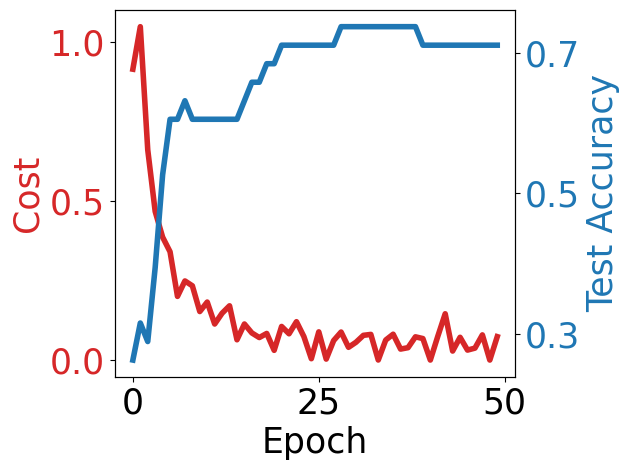

In [104]:
import matplotlib.pyplot as plt

crop = 50

fig, ax1 = plt.subplots()
iters = np.arange(0, crop, 1)
colors = ["tab:red", "tab:blue"]
ax1.set_xlabel("Epoch", fontsize=25)
ax1.set_ylabel("Cost", fontsize=25, color=colors[0])
ax1.plot(iters, costs[:crop], color=colors[0], linewidth=4)
ax1.tick_params(axis="y", labelsize=25, labelcolor=colors[0])
ax1.tick_params(axis="x", labelsize=25)
ax1.set_yticks([0.0, 0.5, 1.0])

ax2 = ax1.twinx()
ax2.set_ylabel("Test Accuracy", fontsize=25, color=colors[1])
ax2.plot(iters, test_acc[:crop], color=colors[1], linewidth=4)

ax2.tick_params(axis="x", labelsize=25)
ax2.tick_params(axis="y", labelsize=25, labelcolor=colors[1])
ax2.set_xticks([0,25,50])
ax2.set_yticks([0.3, 0.5, 0.7])

plt.grid(False)
plt.tight_layout()
plt.show()

### Classical Neural Network

In [7]:
# def classicalNN(X, y, inputdim):
#   keras.backend.set_floatx('float64')
#   model = keras.models.Sequential([
#                                   layers.Dense(16, activation ="relu", input_dim = inputdim),  
#                                   #layers.Dense(64, activation ="relu", input_dim = 33), 
#                                   layers.Dense(16, activation ="relu")     # corresponds to the number of qubits we need
#                                   ])
#   model.summary()
#   model.compile(loss = 'mean_squared_error', metrics =['accuracy'], optimizer = 'adam')
#   #model.compile(optimizer='adam', loss=tf.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
#   model.fit(X, y, epochs = 30, batch_size = 64)
#   qvc_input = model.predict(X)
#   return qvc_input

# qvc_input = classicalNN(X, y, X_feature_size)

#opt = keras.optimizers.SGD(learning_rate = 0.002)
#model.compile(loss = 'mean_squared_error', metrics =['accuracy'], optimizer = 'adam')
#classical = model.fit(X, y,epochs = 30, batch_size = 64)
#qvc_input = model.predict(X)
# print(qvc_input.shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                80        
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
Total params: 352
Trainable params: 352
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
3/3 [==============================] - 7s 21ms/step - loss: 1.5464 - accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 0s 12ms/step - loss: 1.4403 - accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 0s 10ms/step - loss: 1.3466 - accuracy: 0.0000e+00
Epoch 4/30
3/3 [==============================] - 0s 8ms/step - loss: 1.2646 - accuracy: 0.0000e+00
Epoch 5/30
3/3 [==============================] - 0